In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from datetime import date

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

mpl.rcParams['pdf.fonttype'] = 42

sns.set(style="ticks")

%matplotlib inline

In [2]:
# Update the files if the data change
hom_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Homomers summary')
het_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Heteromers Summary')
het_ramps_df = pd.read_excel('ramps_results_Mar18_fullHet.xlsx')
hom_ramps_df = pd.read_excel('ramps_results_Hom_full.xlsx')

In [3]:
# replace mutants with consistent nomenclature
names = {'PQK528-530Del':'P528-530Del', '528Del':'P528-530Del', 'GRIA1':'—'}
data_frames = [hom_amp_df, het_amp_df, hom_ramps_df, het_ramps_df]

for df in data_frames:
    df['Mutant'] = df['Mutant'].apply(lambda x: names[x] if x in names else x)

In [4]:
hom_amp_df.columns

Index(['Date', 'Mutant', 'Record', 'KA Holding current', 'KA Amplitude',
       'CTZ Holding current', 'CTZ Amplitude', 'Glu Holding current',
       'Glu Amplitude', 'KA Holding current.1', 'KA Amplitude.1'],
      dtype='object')

# Export files (wide data for stats in Prism)

In [5]:
#Tuple that gives the df, the column to extract and the name of the data
export_df_info = ((hom_amp_df,'KA Amplitude','homomer_KAamp'),
                  (het_amp_df,'KA Amplitude','heteromer_KAamp'),
                  (hom_amp_df, 'KA Holding current', 'hom_holding'),
                  (het_amp_df, 'KA Holding current', 'het_holding'),
                  (hom_ramps_df, 'RI', 'homomer_ramps',),
                  (het_ramps_df, 'RI', 'heteromer_ramps',))


def make_excel(project):
    d = date.today().strftime('%y%m%d')
    filename = d+project+'.xlsx'
    File = pd.ExcelWriter(filename)
    return File

def wide_table(df, name, data_col, excel_ob):
    '''data_col specifies the data you want to keep. 
    The function assumes that Mutant will become the index'''
    df = df.pivot(columns='Mutant', values=data_col).apply(lambda x: pd.Series(x.dropna().values))
    df = df.dropna(axis=1, how='all')
    df.to_excel(excel_ob, sheet_name=name, index=False)
    
def export_tables(info_tuple, project='GRIA_wide_data'):
    '''first, initialises an excel object as the save file.
    Then, iterate through the list of df putting each in a new sheet with matching name'''
    file = make_excel(project)
    for df, data_col, name in info_tuple:
        wide_table(df=df, data_col=data_col, name=name, excel_ob=file)
    file.save()
    
export_tables(export_df_info)

#This works beautifully but data are not sorted, Need to sort to make the stats easier
     

# Identify the mutants to include in graphs

In [6]:
# define the mutants that will be included in different figures
# these are in positional order

# total mutants in the paper; needed for colors
all_mutants = ['WT', '—', 'G47E', 'D302G', 'I375V', 'P528T', 'P528-530Del', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'A643T', 'F644L', 'T646N', 'V647L',]

# main figures will exclude non-clinical mutants
main_mutants = ['—', 'WT', 'G47E', 'D302G', 'P528T', 'P528-530Del', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'F644L', 'T646N', 'V647L',]

# non-clinical mutants go in supplemantary: snp and Lurcher
supp_mutants = ['WT', '—', 'I375V', 'A643T']

15


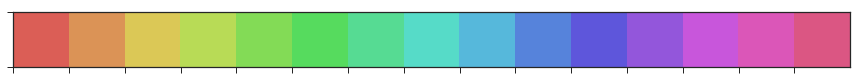

In [7]:
# Assign a consistent colorscheme:
rgb15 = sns.color_palette('hls', n_colors=15)
print(len(rgb15))
sns.palplot(rgb15)

#'Paired' is also good but only 12

In [8]:
color_dict = dict(zip(all_mutants, rgb15))

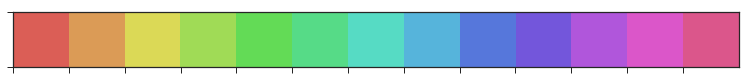

In [9]:
pal2 = sns.color_palette('hls', n_colors=13)
sns.palplot(pal2)

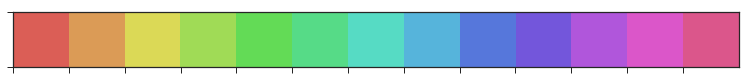

In [10]:
sns.palplot(pal2)

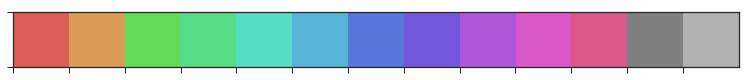

In [11]:
#drop the 2 lightest colors & use grey shades for controls

pal2 = pal2[0:2] + pal2[4:]
color_dict2 = dict(zip(main_mutants[2:], pal2))
color_dict2['WT'] = (0.5,0.5,0.5)
color_dict2['—'] = (0.7,0.7,0.7)

sns.palplot(color_dict2.values())

# Plot & save functions

In [12]:
# Put all the plotting in one function

def save_fig(name, fig_object):
    d = date.today().strftime('%y%m%d')
    filename = d+name+'.pdf'
    plt.savefig(filename, transparent=True)
    pass

    
def sem_ordered(df, x, y, order):
    sem_df = df.groupby(x)[y].sem()
    sem_list = []
    for m in order:
        sem_list.append(sem_df[m])
    return sem_list
    

def barplot_swarmplot_format(df, x, y, title, ylabel='Amplitude (nA)', fontsize=16, order=main_mutants, pal=color_dict2,
                            convert_pA=True): 
    ''''''
    # dodgy way of checking if the y is in pA; converting to nA
    if convert_pA:
        df[y]=df[y]/1000
        
    yerr = sem_ordered(df=df, x=x, y=y, order=order)
    sns.barplot(x=df[x], y=df[y], ci=None, order=order, alpha=1, palette=color_dict2, yerr=yerr, capsize=20)
    sns.swarmplot(x=df[x], y=df[y], color='k', size=3.5, order=order)
    
    sns.set_style("ticks", {"axes.linewidth": 1})
    plt.xticks(range(len(order)), order, rotation=45, size=fontsize, ha='right')
    plt.xlabel('')
    plt.yticks(size=fontsize)
    plt.ylabel(ylabel, size=fontsize)
    sns.despine()
    plt.tight_layout()
    plt.title(title, size=fontsize)
    pass


# Figure 1: homomer amplitude

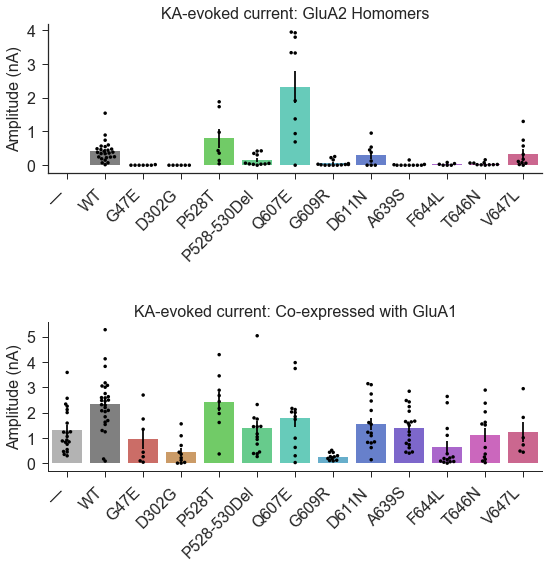

In [13]:
# make figure 1
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

#plt.savefig('Amplitude_resub_March_Color.pdf', transparent=True)
save_fig('Amplitude_resub_', fig)

plt.show()

# figure S1: Other mutants

# figure S2: holding current

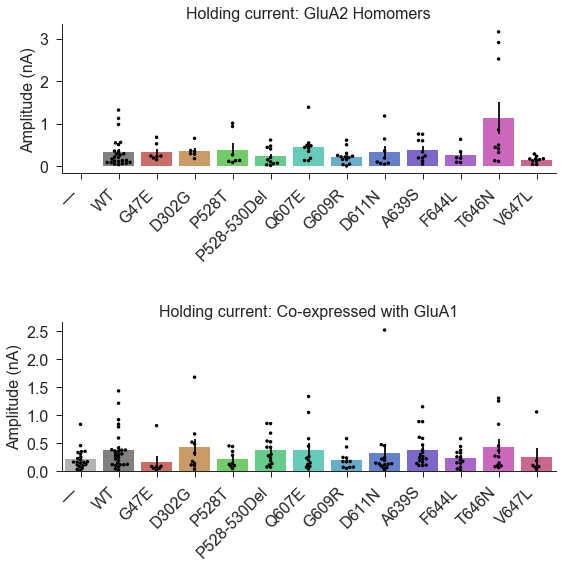

In [14]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Holding current', title='Holding current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Holding current', title='Holding current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

#plt.savefig('Amplitude_resub_March_Color.pdf', transparent=True)
save_fig('Holding_resub', fig)

plt.show()

# Heteromer expression data: GluR1 and GluR2

In [15]:
# Use sns.axes_style() to output style parameters


#Annotation:

y = (gluR1_df['KA Amplitude'][gluR1_df['Mutant']=='GRIA1'].max()/1000)
h = y*1.3

signif = ['', '**', '****', '**', '**']

def sig_stars(h, star_list, color='black', size=24):
    for x in range(0, len(star_list)):
        plt.text(x, h, star_list[x], ha='center', va='bottom', color=color, size=size)
        pass



plt.figure(figsize=(12,6))
fig = sns.swarmplot(x=gluR1_df['Mutant'], y=(gluR1_df['KA Amplitude']/1000), order=resub_mutants, 
                    color='black')


#fig.map(plt.hist,'Outstate',bins=20,alpha=0.7)



#sig_stars(h, signif, color='red', size=20)

#fig = sns.boxplot(x=gluR1_df['Mutant'], y=(gluR1_df['KA Amplitude']/1000), order=resub_mutants, 
                  #saturation=1, width=0.4, boxprops=dict(alpha=.3), showfliers=False)
    
sns.barplot(x=gluR1_df['Mutant'], y=(gluR1_df['KA Amplitude']/1000), order=resub_mutants, 
                  saturation=1, )  
swarmplot_format()


#plt.savefig('181121_KA_amp_hetero_black_small.pdf')


# Calculate t-test p-values
WT_gluR1_df = gluR1_df[gluR1_df['Mutant'] == 'WT']

# the number unpacks the p-value from the returned tuple
rawP_gluR1 = gluR1_df.groupby('Mutant')['KA Amplitude'].apply(lambda x: stats.ttest_ind(x, WT_gluR1_df['KA Amplitude'], 
                                                                              equal_var=False)[1])

print(rawP_gluR1)

NameError: name 'gluR1_df' is not defined

In [ ]:
# Figure out how to add p-values to the graph
# turn p value chart into dict and lookup with star function

def assign_stars(p):
    if p > 0.05:
        return 'ns'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    else:
        return '***'

#rawP_gluR1.to_dict()

GluR1_res = pd.DataFrame(rawP_gluR1)
GluR1_res.columns = ['rawP']
GluR1_res['raw_sig'] = GluR1_res.rawP.apply(lambda x: assign_stars(x))
GluR1_res['bonferroni_p'] = multipletests(rawP_gluR1, method='bonferroni')[1]
GluR1_res['adj_sig'] = GluR1_res.bonferroni_p.apply(lambda x: assign_stars(x))
GluR1_res

In [ ]:
ramps_df.head(10)


In [ ]:

#ramps_df = ramps_df[ramps_df.Mutant.isin(resub_mutants)]
#ramps_df_baby = ramps_df[ramps_df.Mutant != 'V647L']
stats.kurtosis(ramps_df['RI'])

In [ ]:
ramps_df.groupby('Mutant')['RI'].count()

In [ ]:
WT_ramps = ramps_df[ramps_df['Mutant'] == 'WT']

# the number unpacks the p-value from the returned tuple
rawP = ramps_df.groupby('Mutant')['RI'].apply(lambda x: stats.ttest_ind(x, WT_ramps['RI'], equal_var=False)[1])

In [ ]:
rawP

In [ ]:
print(rawP < 0.05)



In [ ]:

p_adjusted = multipletests(rawP, method='bonferroni')

In [ ]:
p_adjusted

In [ ]:
# ramps RI data

plt.figure(figsize=(12,6))
fig = sns.swarmplot(x=ramps_df['Mutant'], y=(ramps_df['RI']*-1), order=resub_mutants, 
                    color='black')
sns.barplot(x=ramps_df['Mutant'], y=(ramps_df['RI']*-1), order=resub_mutants, 
                  saturation=1, )  
swarmplot_format(ylabel='RI')


In [ ]:
# For supplementary: 
# Check this: do the labels line up properly?

sns.swarmplot(x=gluR1_df['Mutant'], y=(gluR1_df['KA Holding current']/1000), color='k')
swarmplot_format(ylabel='Holding current (nA)', fontsize=16, )
#plt.savefig('Heteromer_holding_supp3_bw.pdf', transparent=True)

# Plot the RI against the amplitude

In [ ]:
ramps_df.head(1)

In [ ]:
# make a colourscheme for the scatterplot

control_wt = 'black'
control_pos = 'grey'
gate = 'green'
linker = 'purple'
Nterm = 'blue'
Select = 'red'


scatter_cmap = {'WT':control_wt, 'GRIA1':control_pos, 'G47E':Nterm, 'D302G':Nterm,'I375V':control, 'P528T':linker, 
                '528Del':linker, 'Q607E':Select, 'G609R':Select, 'D611N':Select, 
                 'A639S':gate, 'F644L':gate, 'T646N':gate, 'V647L':gate}

# Don't use this: use color_dict

In [ ]:
for row in range(len(het_ramps_df)):
    data = het_ramps_df.iloc[row]
    x = data['-70mV I']*-1
    y = data['RI']
    m = data['Mutant']

    if m in color_dict.keys():
        c = color_dict[m]
        plt.scatter(x,y,color=c,alpha=0.8)

    

plt.show()

In [ ]:
ramps_paper = het_ramps_df[het_ramps_df['Mutant'] != 'W788L']
DK_scatter = ramps_paper.groupby('Mutant')[['-70mV I','RI']].mean()
DK_scatter.head(3)

In [ ]:
# Need to add in the statistics here. Maybe 528T has a sig reduced RI?

DK_error = ramps_paper.groupby('Mutant')[['-70mV I','RI']].sem()

In [ ]:
DK_error.columns

In [ ]:


fig = plt.figure(figsize=(10,10
                         ))

#plt.scatter(x=DK_scatter['-70mV I']*-1, y=DK_scatter['RI'])
plt.xlabel('KA max I (pA)', fontsize=14)
plt.ylabel('RI', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.errorbar(x=DK_scatter['-70mV I']*-1, y=DK_scatter['RI'], xerr=DK_error['-70mV I'], 
             yerr=DK_error['RI'], fmt='o', alpha=1, )

#add tags
for row in range(len(DK_scatter)):
    label = DK_scatter.index[row]
    x = DK_scatter['-70mV I'][row]
    y = DK_scatter['RI'][row]
    plt.text((x*-1)+20,y+0.01,label, fontsize=13)
   
    
sns.despine()
plt.savefig('MaxI_vsRI_resub_draft.pdf')
plt.show()

In [ ]:

    
mutant_order = ['WT', 'G609R', 'A639S', 'T646N']
paper_mutants = ['WT', 'GRIA1', 'G609R', 'A639S', 'T646N']

df_plot = df[df['Mutant'].isin(paper_mutants)]

poster_pal_UCL = {'WT':'#0097a9', 'GRIA1':'#d50032', 'G609R':'#f6be00', 'A639S':'#8f993e', 'T646N':'#500778'} #only used for poster

plt.figure(figsize=(3.5,4))
fig = sns.swarmplot(x=df_plot['Mutant'], y=(df_plot['KA Amplitude']/1000), order=mutant_order, color='black')
swarmplot_format(xlabels=('WT', 'G609R', 'A639S', 'T646N'))


#Annotation:

y = (df_plot['KA Amplitude'][df_plot['Mutant']=='G609R'].max())/1000
h = y*3.5

signif = ['', '***', '***', '***']
sig_stars(h, signif, color='red', size=20)

for label in fig.get_yticklabels()[::2]:
    label.set_visible(False)

plt.savefig('G2_homomers_paper_small.pdf')
plt.show()


In [ ]:
#Take the 2 columns we need to graph
Amp = df[['Mutant', 'KA Amplitude']]
Hold = df[['Mutant', 'KA Holding current']]

In [ ]:
AmpG = Amp.groupby('Mutant')
HoldG = Hold.groupby('Mutant')

In [ ]:
A = AmpG.agg(['mean', 'sem'])
H = HoldG.agg(['mean', 'sem', 'count'])
summary = pd.concat([A,H], axis=1).round(0)
#concatenate the 2 df, matching the axis(??) then remove the decimals with round